In [97]:
import os
import pandas as pd

In [98]:
games = {}
times = {}
for game in os.listdir("games"):
    if game.endswith(".csv"):
        game_path = os.path.join("games", game)
        df = pd.read_csv(game_path)
        if df['Difficulty_Level'].iloc[0] != 0 or df['Track_ID'].iloc[0] != 1 or df.shape[0] < 10 or df['Completed.1'].iloc[0] != True:
            continue
        #add ID and game to games dict
        game_id = game.split(".")[0]
        games[game_id] = df[["Points_X", "Points_Y"]]
        times[game_id] = df['Time'].iloc[0]

In [99]:
import numpy as np
def calculate_smoothness(x, y):
    x = np.array(x)
    y = np.array(y)

    if len(x) < 3:
        return 0

    dx1 = x[1:-1] - x[:-2]
    dy1 = y[1:-1] - y[:-2]
    dx2 = x[2:] - x[1:-1]
    dy2 = y[2:] - y[1:-1]

    dot = dx1 * dx2 + dy1 * dy2
    mag1 = np.sqrt(dx1**2 + dy1**2)
    mag2 = np.sqrt(dx2**2 + dy2**2)

    cos_angle = np.clip(dot / (mag1 * mag2 + 1e-8), -1.0, 1.0)
    angles = np.arccos(cos_angle)

    # Penalize sharp turns more heavily
    penalized_angles = angles ** 2

    path_length = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
    smoothness = np.sum(penalized_angles) / (path_length + 1e-8)

    return smoothness


In [100]:
smoothnesses = pd.DataFrame(columns=['Game_ID', 'Smoothness'])

for game_id, game_df in games.items():
    x = game_df['Points_X'].iloc[1:-1]
    y = game_df['Points_Y'].iloc[1:-1]

    smoothness = calculate_smoothness(x, y)

    smoothnesses = pd.concat(
        [smoothnesses, pd.DataFrame({'Game_ID': [game_id], 'Smoothness': [smoothness]})],
        ignore_index=True
    )


/var/folders/yx/857vdk_j67j9v688jjd81j8c0000gn/T/ipykernel_70749/760895709.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  smoothnesses = pd.concat(


In [101]:
smoothnesses

,Game_ID,Smoothness
0,20240213-0034_12:59:50:832,0.097953
1,20240530-0034_12:14:37:543,0.220669
2,20240807-0064_17:17:45:423,0.086138
3,20240216-0090_17:07:07:199,0.064911
4,20240321-0042_13:45:33:938,0.098404
...,...,...
6746,20240403-0016_11:57:20:428,0.078250
6747,20240206-0083_16:05:51:269,0.137048
6748,20240430-0036_13:23:15:376,0.028130
6749,20240521-0031_11:44:48:505,0.197278


In [102]:
#max 10 smoothnesses
max_smoothnesses_ids = smoothnesses.nlargest(5, 'Smoothness')['Game_ID']

#min 10 smoothnesses
min_smoothnesses_ids = smoothnesses.nsmallest(5, 'Smoothness')['Game_ID']


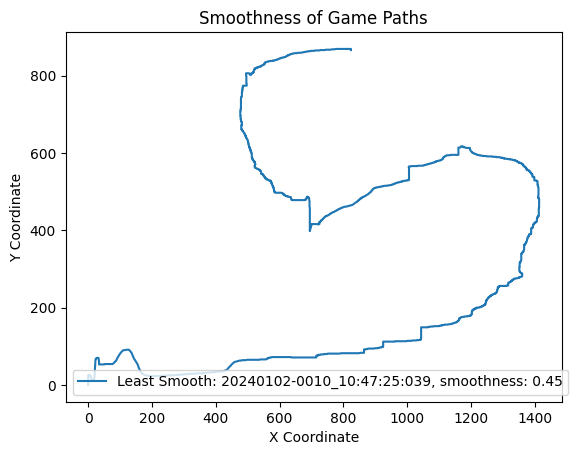

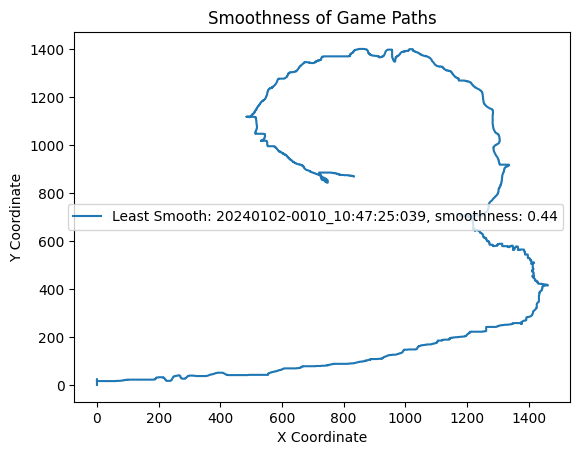

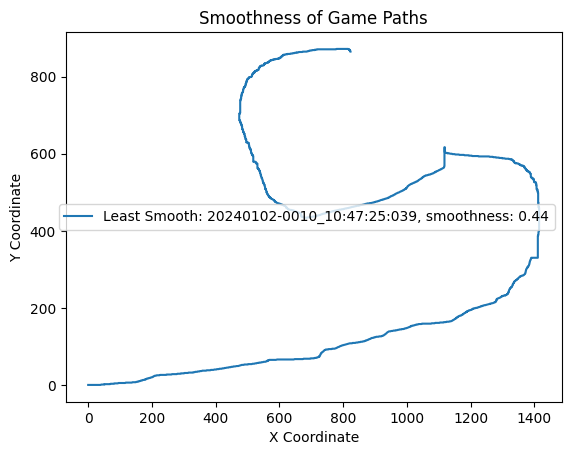

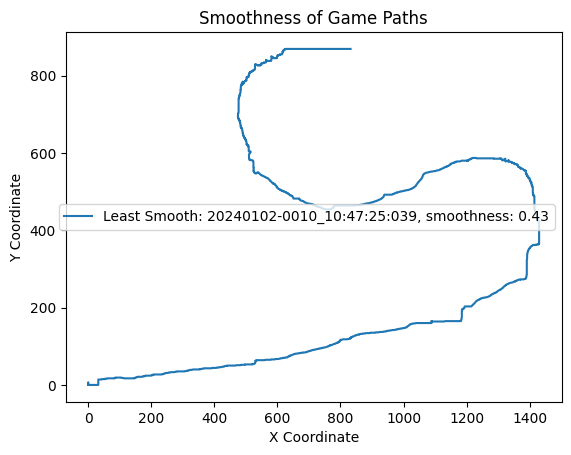

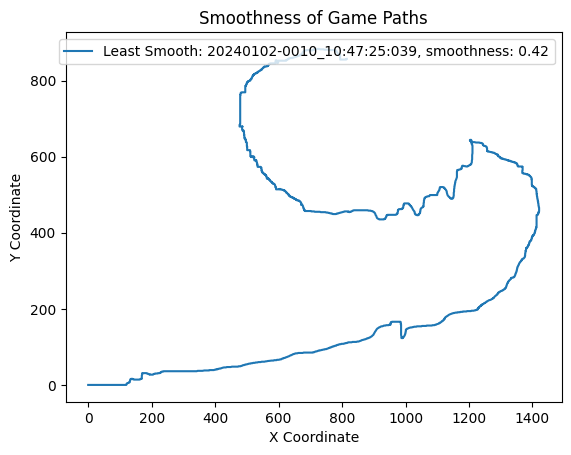

In [103]:
#plot 10 most smoth 
import matplotlib.pyplot as plt
import seaborn as sns
for id in max_smoothnesses_ids:
    game = games[id]
    plt.plot(game['Points_X'].iloc[1:-1], game['Points_Y'].iloc[1:-1], label=f'Least Smooth: {game_id}, smoothness: {smoothnesses[smoothnesses["Game_ID"] == id]["Smoothness"].values[0]:.2f}')

    plt.title('Smoothness of Game Paths')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

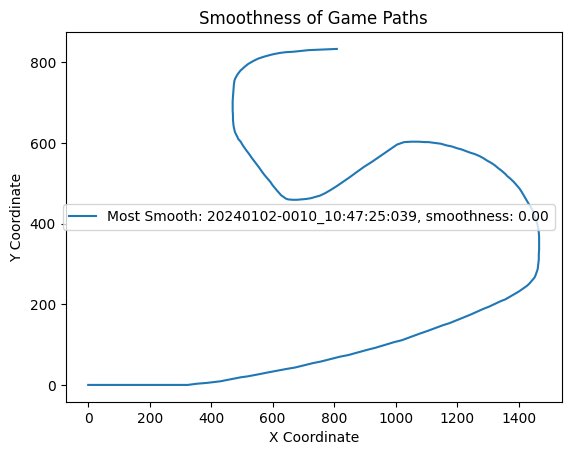

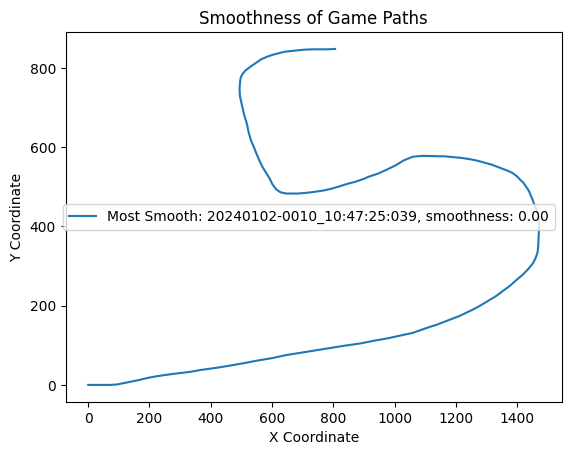

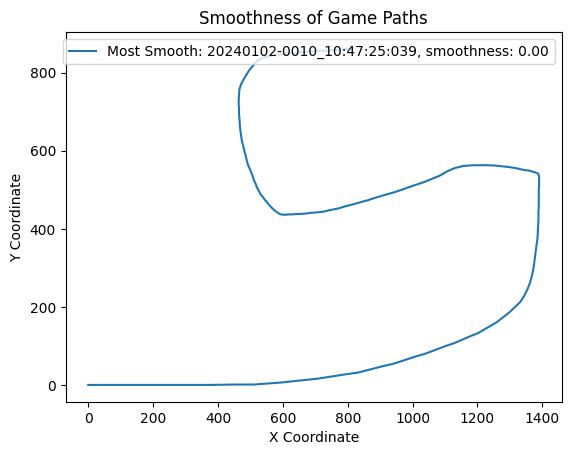

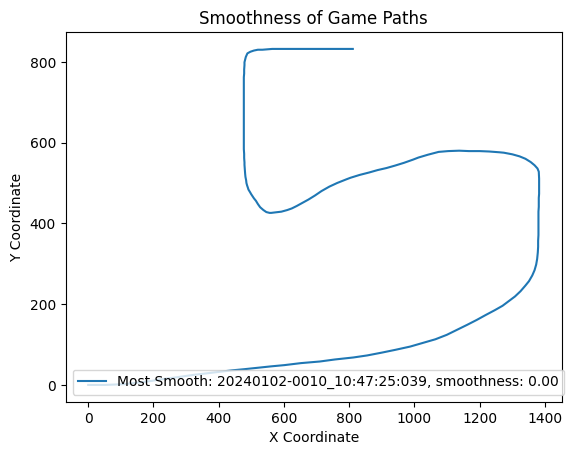

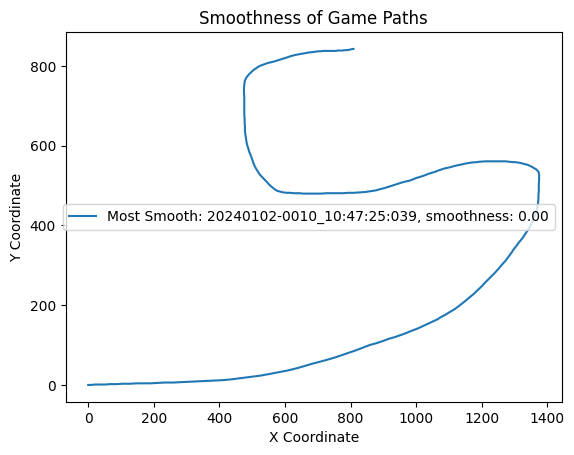

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
for id in min_smoothnesses_ids:
    game = games[id]
    plt.plot(game['Points_X'].iloc[1:-1], game['Points_Y'].iloc[1:-1], label=f'Most Smooth: {game_id}, smoothness: {smoothnesses[smoothnesses["Game_ID"] == id]["Smoothness"].values[0]:.2f}')

    plt.title('Smoothness of Game Paths')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

In [105]:
import numpy as np

def calculate_stair_ratio(x, y):
    x = np.array(x)
    y = np.array(y)
    
    dx = np.diff(x)
    dy = np.diff(y)
    
    # Check if only one coordinate changes per segment
    one_coord_changes = ((dx == 0) & (dy != 0)) | ((dx != 0) & (dy == 0))
    stair_ratio = np.sum(one_coord_changes) / len(dx)
    
    return stair_ratio


In [106]:
stair_ratios = pd.DataFrame(columns=['Game_ID', 'Stair_Ratio'])
for game_id, game_df in games.items():
    x = game_df['Points_X'].iloc[1:-1]
    y = game_df['Points_Y'].iloc[1:-1]
    stair_ratio = calculate_stair_ratio(x, y)
    stair_ratios = pd.concat(
        [stair_ratios, pd.DataFrame({'Game_ID': [game_id], 'Stair_Ratio': [stair_ratio]})],
        ignore_index=True
    )
    
stair_ratios

/var/folders/yx/857vdk_j67j9v688jjd81j8c0000gn/T/ipykernel_70749/4048639554.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stair_ratios = pd.concat(


,Game_ID,Stair_Ratio
0,20240213-0034_12:59:50:832,0.781975
1,20240530-0034_12:14:37:543,0.796050
2,20240807-0064_17:17:45:423,0.771847
3,20240216-0090_17:07:07:199,0.756058
4,20240321-0042_13:45:33:938,0.720745
...,...,...
6746,20240403-0016_11:57:20:428,0.661716
6747,20240206-0083_16:05:51:269,0.677045
6748,20240430-0036_13:23:15:376,0.615250
6749,20240521-0031_11:44:48:505,0.806678


In [107]:
max_stair_ratios_ids = stair_ratios.nlargest(5, 'Stair_Ratio')['Game_ID']
min_stair_ratios_ids = stair_ratios.nsmallest(5, 'Stair_Ratio')['Game_ID']

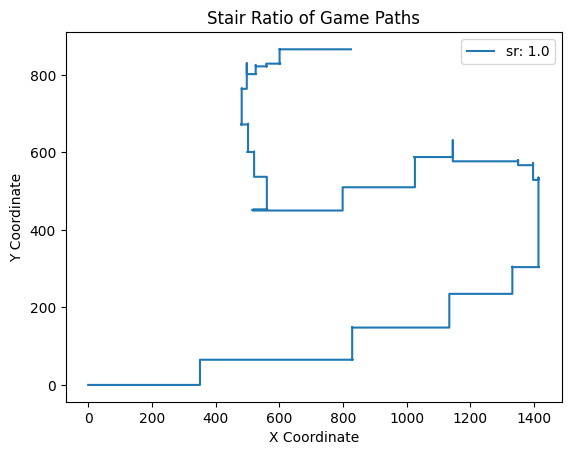

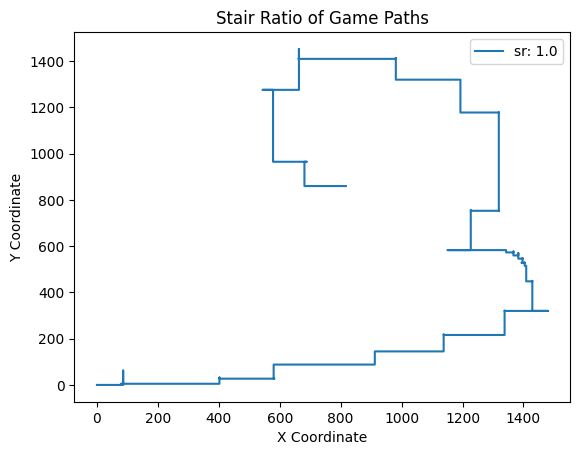

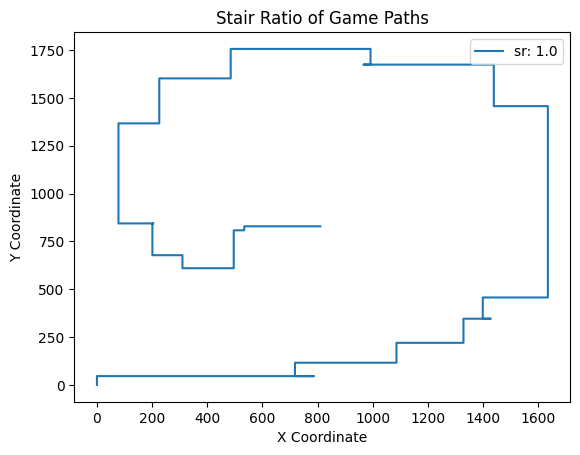

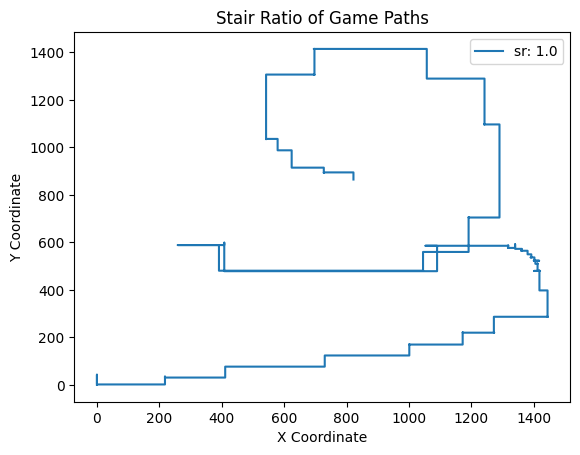

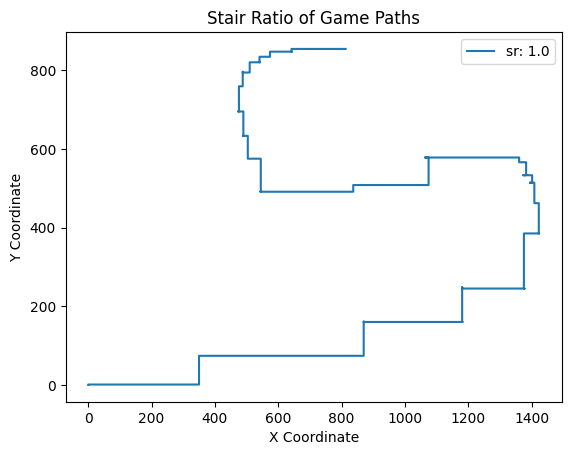

In [108]:
#plot the biggest 10 stair ratios
import matplotlib.pyplot as plt
import seaborn as sns
for game_id in max_stair_ratios_ids:
    game = games[game_id]
    plt.plot(game['Points_X'].iloc[1:-1], game['Points_Y'].iloc[1:-1], label=f'sr: {stair_ratios[stair_ratios["Game_ID"] == game_id]["Stair_Ratio"].values[0]}')

    plt.title('Stair Ratio of Game Paths')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

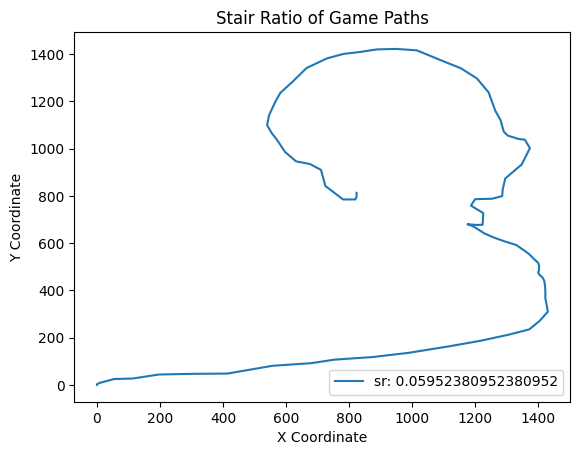

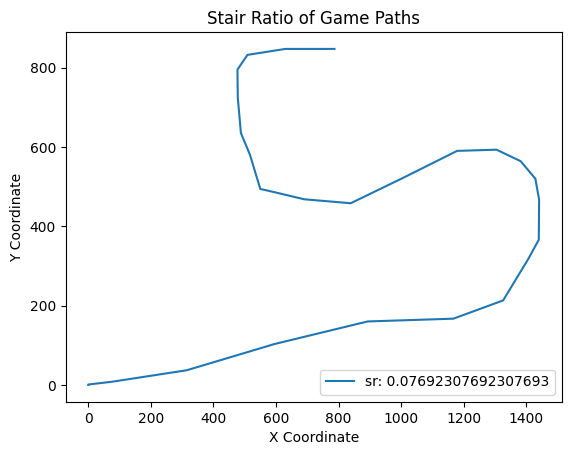

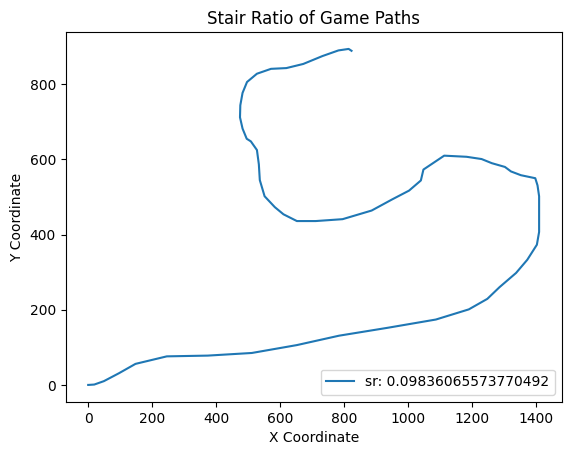

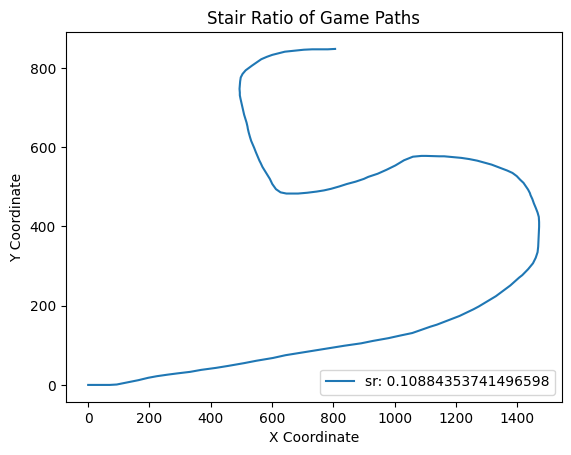

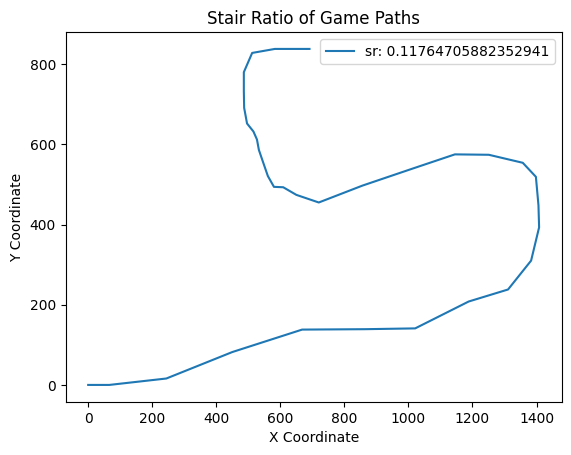

In [109]:
for game_id in min_stair_ratios_ids:
    game = games[game_id]
    plt.plot(game['Points_X'].iloc[1:-1], game['Points_Y'].iloc[1:-1], label=f'sr: {stair_ratios[stair_ratios["Game_ID"] == game_id]["Stair_Ratio"].values[0]}')

    plt.title('Stair Ratio of Game Paths')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.show()

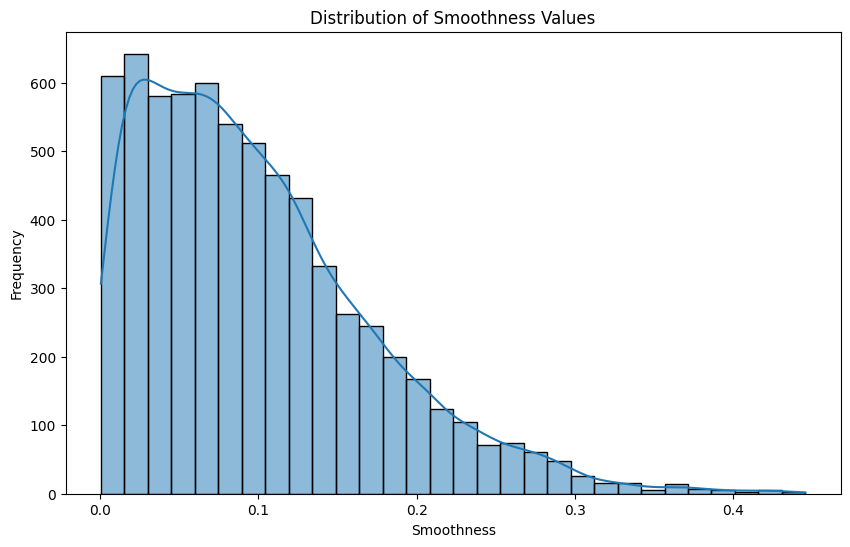

In [110]:
#histogra of smoothnesses
import matplotlib.pyplot as plt 
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(smoothnesses['Smoothness'], bins=30, kde=True)
plt.title('Distribution of Smoothness Values')
plt.xlabel('Smoothness')
plt.ylabel('Frequency')
plt.show()

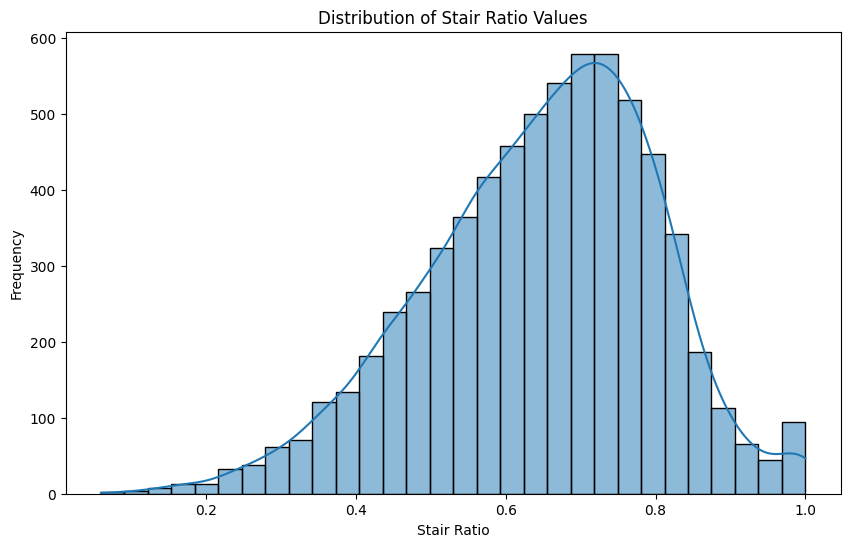

In [111]:
#histogram of stair ratios
plt.figure(figsize=(10, 6))

sns.histplot(stair_ratios['Stair_Ratio'], bins=30, kde=True)
plt.title('Distribution of Stair Ratio Values')
plt.xlabel('Stair Ratio')
plt.ylabel('Frequency')
plt.show()

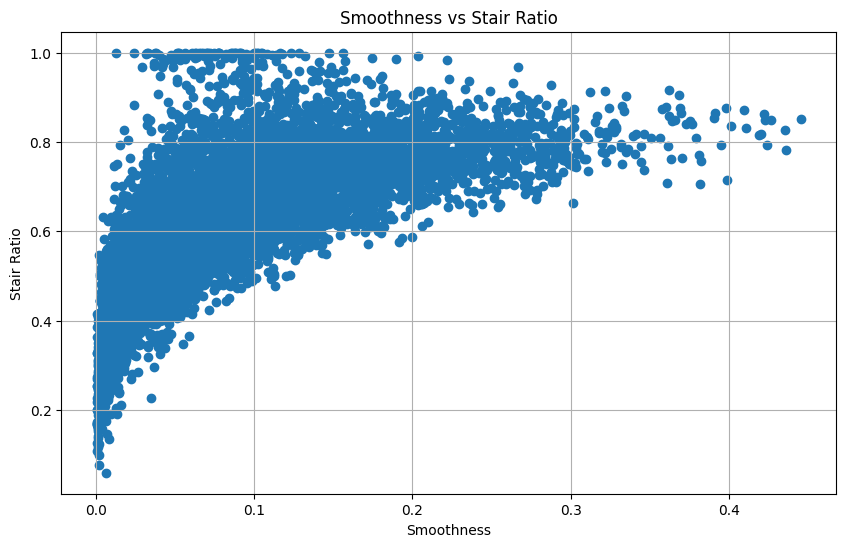

In [112]:
#plot stair ratio vs smoothness
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(smoothnesses['Smoothness'], stair_ratios['Stair_Ratio'])
plt.title('Smoothness vs Stair Ratio')
plt.xlabel('Smoothness')
plt.ylabel('Stair Ratio')
plt.grid()
plt.show()

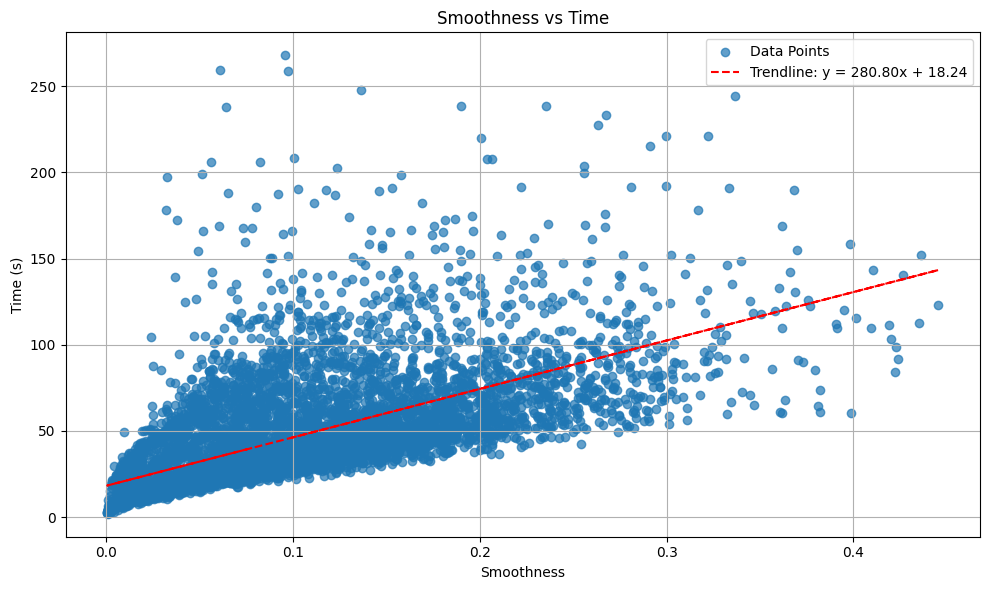

In [113]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))

x = smoothnesses['Smoothness']
y = list(times.values())
y = [i / 1000 for i in y]
# Scatter plot
plt.scatter(x, y, alpha=0.7, label='Data Points')

# Trendline (Linear)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label=f"Trendline: y = {z[0]:.2f}x + {z[1]:.2f}")

# Labels and layout
plt.title('Smoothness vs Time')
plt.xlabel('Smoothness')
plt.ylabel('Time (s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


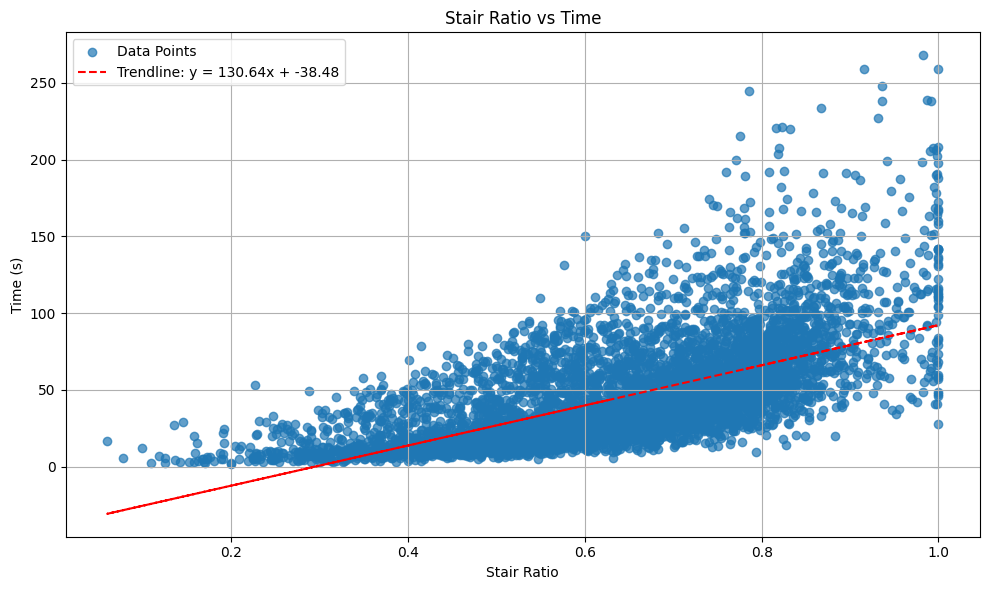

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Assume: stair_ratios is a DataFrame with 'Stair_Ratio' column
# and times is a dictionary keyed by Game_ID or index-matched list

plt.figure(figsize=(10, 6))
x = stair_ratios['Stair_Ratio']
y = list(times.values())
y = [i / 1000 for i in y]

# Scatter plot
plt.scatter(x, y, alpha=0.7, label='Data Points')

# Trendline
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label=f"Trendline: y = {z[0]:.2f}x + {z[1]:.2f}")

# Labels and layout
plt.title('Stair Ratio vs Time')
plt.xlabel('Stair Ratio')
plt.ylabel('Time (s)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
